training with (data_Dion/3654_combined_dataset.csv)

encountering cuda out of memory error, 

to fix: changing up batch size: originally 32, down to 16, 8, 2, didn't fix the error, but it's reducing the needed memory

to fix: changing up the model (gpt-2) config (info from hugginface): originally n_embd=768, n_layer=12, n_head=12. 
changing it to n_emb = 512, n_layer = 8, n_head = 8, if encountering other errors, switch back to n_emb = 768

/home/dion/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


/home/dion/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/dion/.local/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training Loss: 1.3210, Validation Loss: 0.3880
Epoch 2, Training Loss: 0.3401, Validation Loss: 0.3078
Epoch 3, Training Loss: 0.2847, Validation Loss: 0.2747
Epoch 4, Training Loss: 0.2555, Validation Loss: 0.2425
Epoch 5, Training Loss: 0.2349, Validation Loss: 0.2305
Epoch 6, Training Loss: 0.2206, Validation Loss: 0.2168
Epoch 7, Training Loss: 0.2088, Validation Loss: 0.2104
Epoch 8, Training Loss: 0.2003, Validation Loss: 0.2037
Epoch 9, Training Loss: 0.1915, Validation Loss: 0.1956
Epoch 10, Training Loss: 0.1851, Validation Loss: 0.1954
Epoch 11, Training Loss: 0.1787, Validation Loss: 0.1855
Epoch 12, Training Loss: 0.1739, Validation Loss: 0.1853
Epoch 13, Training Loss: 0.1686, Validation Loss: 0.1814
Epoch 14, Training Loss: 0.1635, Validation Loss: 0.1794
Epoch 15, Training Loss: 0.1602, Validation Loss: 0.1795
Epoch 16, Training Loss: 0.1561, Validation Loss: 0.1769
Epoch 17, Training Loss: 0.1529, Validation Loss: 0.1748
Epoch 18, Training Loss: 0.1491, Validat

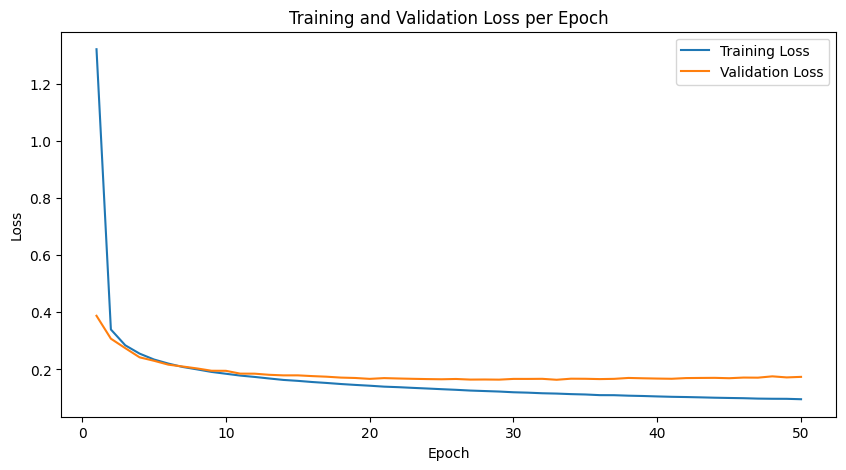

('polymer_gpt_3654/tokenizer_config.json',
 'polymer_gpt_3654/special_tokens_map.json',
 'polymer_gpt_3654/vocab.json',
 'polymer_gpt_3654/merges.txt',
 'polymer_gpt_3654/added_tokens.json')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Config, GPT2Tokenizer, GPT2LMHeadModel, AdamW
import torch.nn as nn

# Set the device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the dataset
df = pd.read_csv('/home/dion/projects/New_TransPolymer/TransPolymer/Dion/data_Dion/3654_combined_dataset.csv')
properties = df.drop(columns=['smiles'])
smiles_strings = df['smiles']

# Split the dataset into training and test sets
properties_train, properties_test, smiles_train, smiles_test = train_test_split(
    properties, smiles_strings, test_size=0.2, random_state=42
)

# Define the PolymerDataset class
class PolymerDataset(Dataset):
    def __init__(self, properties, smiles):
        self.properties = properties.reset_index(drop=True)
        self.smiles = smiles.reset_index(drop=True)
            
    def __len__(self):
        return len(self.smiles)
    
    def __getitem__(self, idx):
        return self.properties.iloc[idx].values, self.smiles.iloc[idx]

# Create datasets and dataloaders for training and test sets
dataset_train = PolymerDataset(properties_train, smiles_train)
dataset_test = PolymerDataset(properties_test, smiles_test)

dataloader_train = DataLoader(dataset_train, batch_size=2, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=2, shuffle=False)

# Load pre-trained GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Add padding token to the tokenizer
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Extend tokenizer to handle property input (optional, for custom tokens)
additional_tokens = [f"<prop_{i}>" for i in range(properties.shape[1])]
tokenizer.add_tokens(additional_tokens) 
    # Create a custom configuration
config = GPT2Config(
    n_embd=256,  # Reduce embedding size
    n_layer=8,   # Reduce number of layers
    n_head=8     # Reduce number of attention heads
)
    # Initialize the model with the custom configuration
model = GPT2LMHeadModel(config)
    # Resize the token embeddings to match the tokenizer
model.resize_token_embeddings(len(tokenizer))

#model = GPT2LMHeadModel.from_pretrained('gpt2') # can change the config
#model.resize_token_embeddings(len(tokenizer))

# Move the model to the device
model.to(device)

# Training setup
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()
num_epochs = 50  # Adjust this number based on your training needs
max_length = 128  # Adjust this based on your dataset

def encode_properties(properties, tokenizer):
    """Encode properties as token IDs."""
    prop_tokens = [f"<prop_{i}>" for i in range(len(properties))]
    prop_ids = tokenizer.convert_tokens_to_ids(prop_tokens)
    return prop_ids

# Initialize lists to store losses
train_losses = []
val_losses = []

# Fine-tuning loop
for epoch in range(num_epochs):
    model.train()  # Switch to training mode
    total_train_loss = 0
    total_val_loss = 0

    # Training loop
    for props, smiles in dataloader_train:
        prop_ids = [encode_properties(p, tokenizer) for p in props]

        # Tokenize SMILES strings
        inputs = tokenizer(smiles, return_tensors='pt', padding=True, truncation=True, max_length=max_length)

        # Concatenate property tokens with SMILES tokens
        input_ids = []
        attention_masks = []
        for i in range(len(inputs['input_ids'])):
            combined_input = prop_ids[i] + inputs['input_ids'][i].tolist()
            # Pad the combined input to max_length
            combined_input = combined_input[:max_length] + [tokenizer.pad_token_id] * max(0, max_length - len(combined_input))
            input_ids.append(combined_input)
            # Create an attention mask
            attention_mask = [1] * len(prop_ids[i]) + inputs['attention_mask'][i].tolist()
            attention_mask = attention_mask[:max_length] + [0] * max(0, max_length - len(attention_mask))
            attention_masks.append(attention_mask)

        input_ids = torch.tensor(input_ids).to(device)
        attention_masks = torch.tensor(attention_masks).to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_masks, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()

    # Validation loop
    model.eval()  # Switch to evaluation mode
    with torch.no_grad():
        for props, smiles in dataloader_test:
            prop_ids = [encode_properties(p, tokenizer) for p in props]
            
            # Tokenize SMILES strings
            inputs = tokenizer(smiles, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
            
            # Concatenate property tokens with SMILES tokens
            input_ids = []
            attention_masks = []
            for i in range(len(inputs['input_ids'])):
                combined_input = prop_ids[i] + inputs['input_ids'][i].tolist()
                # Pad the combined input to max_length
                combined_input = combined_input[:max_length] + [tokenizer.pad_token_id] * max(0, max_length - len(combined_input))
                input_ids.append(combined_input)
                # Create an attention mask
                attention_mask = [1] * len(prop_ids[i]) + inputs['attention_mask'][i].tolist()
                attention_mask = attention_mask[:max_length] + [0] * max(0, max_length - len(attention_mask))
                attention_masks.append(attention_mask)

            input_ids = torch.tensor(input_ids).to(device)
            attention_masks = torch.tensor(attention_masks).to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_masks, labels=input_ids)
            loss = outputs.loss

            total_val_loss += loss.item()

    # Calculate average losses
    avg_train_loss = total_train_loss / len(dataloader_train)
    avg_val_loss = total_val_loss / len(dataloader_test)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

# Save the fine-tuned model
model.save_pretrained('polymer_gpt_3654')
tokenizer.save_pretrained('polymer_gpt_3654')

42 min training, 

In [2]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the dataset
df = pd.read_csv('/home/dion/projects/New_TransPolymer/TransPolymer/Dion/data_Dion/3654_combined_dataset.csv')
properties = df.drop(columns=['smiles'])
smiles_strings = df['smiles']

# Split the dataset into training and test sets
_, properties_test, _, smiles_test = train_test_split(
    properties, smiles_strings, test_size=0.2, random_state=42
)

# Load the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('polymer_gpt_3654')
model = GPT2LMHeadModel.from_pretrained('polymer_gpt_3654')

# Add the model to the appropriate device
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Define the encode_properties function
def encode_properties(properties, tokenizer):
    """Encode properties as token IDs."""
    prop_tokens = [f"<prop_{i}>" for i in range(len(properties))]
    prop_ids = tokenizer.convert_tokens_to_ids(prop_tokens)
    return prop_ids

# Define the function to generate SMILES strings
def generate_smiles(properties, tokenizer, model, max_length=50):
    prop_ids = encode_properties(properties, tokenizer)
    input_ids = torch.tensor([prop_ids]).to(device)
    
    # Generate SMILES string
    outputs = model.generate(
        input_ids, 
        max_length=max_length, 
        num_return_sequences=1, 
        pad_token_id=tokenizer.pad_token_id, 
        eos_token_id=tokenizer.eos_token_id
    )
    smiles = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return smiles

# Generate SMILES strings for 10 samples from the test set
print("\nGenerated SMILES strings based on test set properties:")
for i in range(5):
    test_properties = properties_test.iloc[i].values
    generated_smiles = generate_smiles(test_properties, tokenizer, model)
    print(f"Sample {i+1}:")
    print(f"Properties: {test_properties}")
    print(f"Generated SMILES: {generated_smiles}\n")

Using device: cuda

Generated SMILES strings based on test set properties:
Sample 1:
Properties: [ 5.3312     nan     nan     nan 17.28       nan     nan]
Generated SMILES: <prop_0> <prop_1> <prop_2> <prop_3> <prop_4> <prop_5> <prop_6> *CCCCCCCCCCCCCCCCCCCCOC(=O)CCCCCCCCCC(=O)O*

Sample 2:
Properties: [6.1422    nan    nan    nan    nan    nan    nan]
Generated SMILES: <prop_0> <prop_1> <prop_2> <prop_3> <prop_4> <prop_5> <prop_6> *CCCCCCCCCCCCCCCCCCCCOC(=O)CCCCCCCCCC(=O)O*

Sample 3:
Properties: [2.0593    nan    nan    nan    nan    nan    nan]
Generated SMILES: <prop_0> <prop_1> <prop_2> <prop_3> <prop_4> <prop_5> <prop_6> *CCCCCCCCCCCCCCCCCCCCOC(=O)CCCCCCCCCC(=O)O*

Sample 4:
Properties: [  nan   nan   nan   nan 74.47   nan   nan]
Generated SMILES: <prop_0> <prop_1> <prop_2> <prop_3> <prop_4> <prop_5> <prop_6> *CCCCCCCCCCCCCCCCCCCCOC(=O)CCCCCCCCCC(=O)O*

Sample 5:
Properties: [5.7766    nan    nan    nan    nan    nan    nan]
Generated SMILES: <prop_0> <prop_1> <prop_2> <prop_3> <p

producing the same smiles